In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import re

from tqdm import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import scale, minmax_scale
from scipy.stats import norm
from sklearn.utils.validation import check_array
from sklearn.metrics import mean_absolute_error

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore')
warnings.filterwarnings('ignore')

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/nba/'
os.chdir(PATH)

## Read in

In [3]:
train = pd.read_csv(f'{PATH}/dataset/df_186.csv')
# test = pd.read_csv(f'{PATH}/dataset/holdout.csv')

train.head()

Engagements  Followers at Posting  ... zo at_signs_rare
0     502093.0              36984682  ...  0             3
1     603380.0              36984682  ...  0             0
2     603380.0              36984682  ...  0             1
3     725100.0              36984682  ...  0             0
4     661446.0              36984682  ...  0             0

[5 rows x 186 columns]

In [4]:
# train.isna().sum()

Engagements                   0
Followers at Posting          0
Created                       0
Type                          0
Description                  14
date                          0
time                          0
tz                            0
date_tsfmYear                 0
date_tsfmMonth                0
date_tsfmWeek                 0
date_tsfmDay                  0
date_tsfmDayofweek            0
date_tsfmDayofyear            0
date_tsfmIs_month_end         0
date_tsfmIs_month_start       0
date_tsfmIs_quarter_end       0
date_tsfmIs_quarter_start     0
date_tsfmIs_year_end          0
date_tsfmIs_year_start        0
date_tsfmElapsed              0
time_split                    0
hour                          0
minute                        0
Type_Album                    0
Type_Photo                    0
Type_Video                    0
num_posts                     0
date_lag_2                    0
num_posts_lag_2               0
                             ..
nbaontnt

In [0]:
train.fillna('', inplace=True)

In [0]:
# len(train), len(test)

In [0]:
tfidf = TfidfVectorizer(analyzer='word',
                     ngram_range=(1,2),
                     min_df=3,
                     max_df=0.05,
                     stop_words='english')

tfidf_matrix = tfidf.fit_transform(train['clean_des'])

vocab = tfidf.get_feature_names()

In [8]:
tfidf_matrix.shape

(7766, 4391)

## Dimensionality reduction
Reduce dimension of TF-IDF matrix from (7,766, 4,391) to (7,766, 100).

In [0]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, n_iter=10, random_state=42)
smaller_d_matrix = svd.fit_transform(tfidf_matrix)

## Feature selection

In [10]:
train.head()

Engagements  Followers at Posting  ... zo at_signs_rare
0     502093.0              36984682  ...  0             3
1     603380.0              36984682  ...  0             0
2     603380.0              36984682  ...  0             1
3     725100.0              36984682  ...  0             0
4     661446.0              36984682  ...  0             0

[5 rows x 186 columns]

There are a few labels we can try out:

*   `Engagement`
*   `Engagement/Followers at Posting`
*   `log(Engagement)`



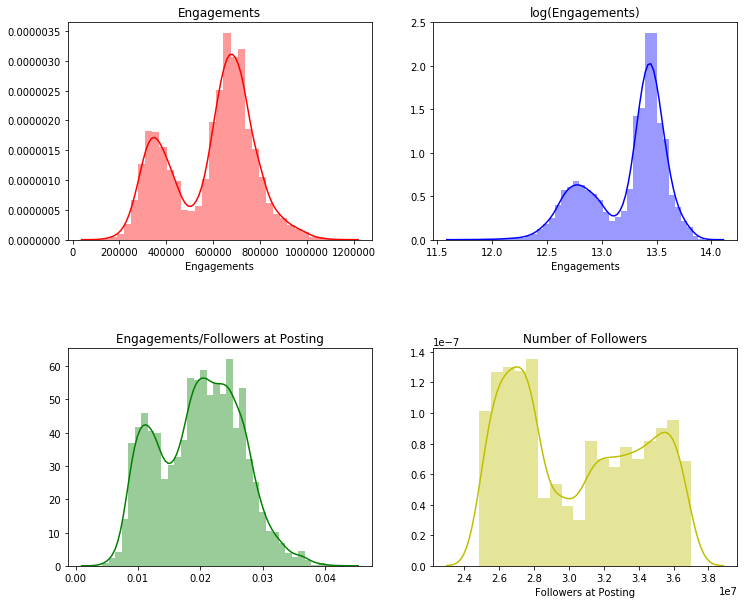

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.distplot(train['Engagements'], 
             ax=axes[0][0], 
             color='r').\
                set_title('Engagements')

sns.distplot(np.log(train['Engagements']), 
             ax=axes[0][1], 
             color='b').\
                set_title('log(Engagements)')

sns.distplot(train['Engagements']/train['Followers at Posting'],
             ax=axes[1][0], 
             color='g').\
                set_title('Engagements/Followers at Posting')

sns.distplot(train['Followers at Posting'], 
             ax=axes[1][1], 
             color='y').\
                set_title('Number of Followers')

plt.subplots_adjust(hspace=0.5)

plt.show()

In [27]:
y = ['Engagements']

exclude = ['Created', 'Type', 'Description', 'date',
           'time', 'tz', 'clean_des', 'date_lag_2',
           'hashes', 'at_signs']

cols = [c for c in train.columns if c not in y and c not in exclude]

len(cols)

# train[cols].head()

175

In [37]:
N = 100

vars = ['var_' + str(i) for i in range(N)]
    
tfidf_df = pd.DataFrame(smaller_d_matrix,
                        columns=vars)

tfidf_df.head()

var_0     var_1     var_2  ...    var_97    var_98    var_99
0  0.035299 -0.023822 -0.011083  ... -0.027003  0.010257 -0.004174
1  0.064111 -0.032155 -0.016581  ... -0.046872 -0.052414 -0.002562
2  0.067397 -0.044799 -0.023316  ...  0.059318 -0.064285 -0.040442
3  0.078836 -0.070167 -0.036142  ... -0.015972 -0.045381 -0.023387
4  0.078163 -0.069234 -0.036752  ... -0.005223 -0.028690 -0.018046

[5 rows x 100 columns]

In [0]:
X_tr = pd.concat([train[cols], tfidf_df], 
                 axis=1)

# X_tr = train['Followers at Posting'].values.reshape(-1, 1)

y_tr = train['Engagements']

## Metric

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def xgb_mape(y_true, dtrain):
    labels = dtrain.get_label()
    return 'mape', np.mean(np.abs((y_true - labels) / y_true)) * 100

## Model

In [0]:
random_state = 42
np.random.seed(random_state)

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

val_mae = []
feature_importance_df = pd.DataFrame()

oof = train[['Engagements']].copy()
oof['predict'] = 0
oof = oof.reset_index(drop=True)

In [0]:
xgb_params = {'objective': 'reg:squarederror',
              'colsample_bytree': 0.3, 
              'learning_rate': 0.1,
              'max_depth': 5, 
              'alpha': 10,}

In [44]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(X_tr, y_tr)):
    X_train, y_train = X_tr.iloc[trn_idx], y_tr[trn_idx]
    X_valid, y_valid = X_tr.iloc[val_idx], y_tr[val_idx]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_valid, label=y_valid)
        
    xgb_clf = xgb.train(xgb_params,
                        dtrain,
                        5000,
                        evals=[(dtrain, 'train'), (dtest, 'valid')],
                        early_stopping_rounds=100,
                        verbose_eval=100,
                        feval=xgb_mape)

    p_valid = xgb_clf.predict(dtest,
                              ntree_limit=xgb_clf.best_ntree_limit)

    oof['predict'][val_idx] = p_valid
    val_score = mean_absolute_percentage_error(y_valid, p_valid)
    val_mae.append(val_score)

[0]	train-rmse:560986	valid-rmse:562591	train-mape:904.509	valid-mape:912.229
Multiple eval metrics have been passed: 'valid-mape' will be used for early stopping.

Will train until valid-mape hasn't improved in 100 rounds.
[100]	train-rmse:25353.8	valid-rmse:36200.2	train-mape:3.49621	valid-mape:5.02979
[200]	train-rmse:17390.2	valid-rmse:31600.5	train-mape:2.38103	valid-mape:4.35955
[300]	train-rmse:14034.2	valid-rmse:30480.2	train-mape:1.89734	valid-mape:4.1956
[400]	train-rmse:11637.2	valid-rmse:30111.2	train-mape:1.54863	valid-mape:4.13445
[500]	train-rmse:9950.21	valid-rmse:29937.5	train-mape:1.31025	valid-mape:4.10112
[600]	train-rmse:8574.93	valid-rmse:29800.5	train-mape:1.10979	valid-mape:4.07809
[700]	train-rmse:7377.61	valid-rmse:29713.9	train-mape:0.9353	valid-mape:4.06707
[800]	train-rmse:6357.28	valid-rmse:29684.7	train-mape:0.791271	valid-mape:4.0637
[900]	train-rmse:5485.22	valid-rmse:29608.7	train-mape:0.674432	valid-mape:4.05128
[1000]	train-rmse:4762.42	valid-rmse:29

In [45]:
mean_mae = np.mean(val_mae)
std_mae = np.std(val_mae)
all_mae = mean_absolute_percentage_error(oof['Engagements'], oof['predict'])
print("Mean mae: %.2f, std: %.2f. All mae: %.2f." % (mean_mae, std_mae, all_mae))

Mean mae: 4.15, std: 0.20. All mae: 4.16.


## Interpretation

In [53]:
import shap

# load JS visualization code to notebook
shap.initjs()

model = xgb.train(xgb_params, 
                  xgb.DMatrix(X_tr, label=y_tr), 100)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_tr)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_tr.iloc[0,:])

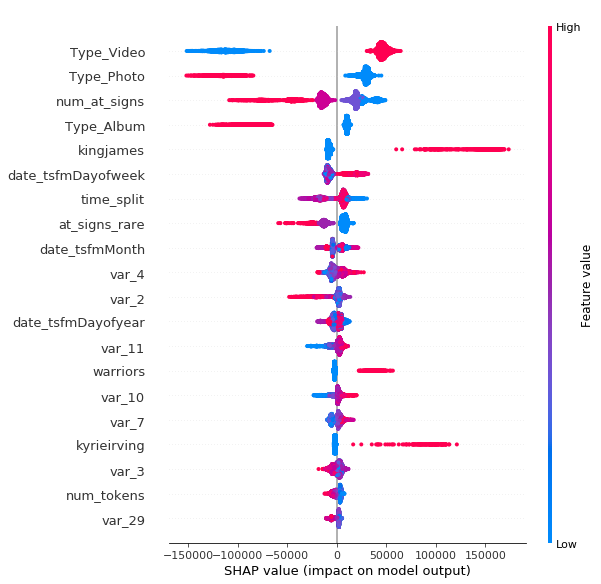

In [54]:
shap.summary_plot(shap_values, X_tr)

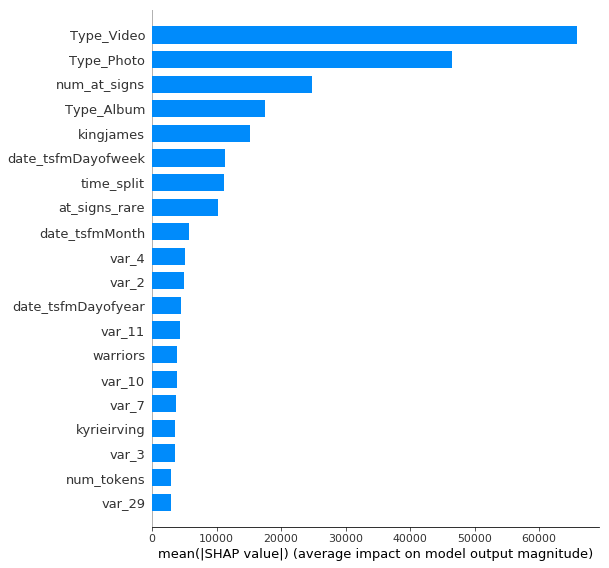

In [55]:
shap.summary_plot(shap_values, X_tr, plot_type="bar")